In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from collections import OrderedDict

from libs.commpy_mod import SISOFlatChannel

from files_01_detection.qam_crazy import crazy_channel_propagate
from files_01_detection.const_mod import generate_symbols, Model
from files_01_detection.const_analyzer import plot_decision_boundary, theoretical_error, ser, plot_confusion_matrix, plot_symbols
 
%matplotlib inline

2023-01-23 19:19:18.917215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 19:19:19.942895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-23 19:19:19.942929: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-23 19:19:20.071915: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-23 19:19:21.862086: W tensorflow/stream_executor/platform/de

In [2]:
Mod = 'QAM'
channel_type = 'awgn' # 'awgn' or 'crazy' or 'rayleigh'
M            = 4      # PSK modulation
total_num_symbols  = 30000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.8 # Fraction of whole data to be used for training (the remaining is for testing)
SNR_dB       = 30      # Signal to noise ratio in dB     
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy

In [3]:
symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB)

In [4]:
symbs_ = symbs[:]

In [5]:
indices = list(OrderedDict.fromkeys(indices))

In [7]:
symbs = np.array(list(OrderedDict.fromkeys(symbs))).reshape(1,-1)

In [8]:
channel_output = channel_output.reshape(-1,1)

In [9]:
symb_min = []
for a in channel_output:
    symb_min.append(symbs[0, np.argmin(np.abs(a - symbs))])

In [10]:
d = dict(zip(symbs[0], indices))

In [11]:
output = []
for i in range(total_num_symbols):
    output.append(d[symb_min[i]])

In [12]:
input = []
for i in range(total_num_symbols):
    input.append(d[symbs_[i]])

In [7]:
def error_symb(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB):
    symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB)
    symbs_ = symbs[:]
    indices = list(OrderedDict.fromkeys(indices))
    symbs = np.array(list(OrderedDict.fromkeys(symbs))).reshape(1,-1)
    channel_output = channel_output.reshape(-1,1)
    
    symb_min = []
    for a in channel_output:
        symb_min.append(symbs[0, np.argmin(np.abs(a - symbs))])
    
    d = dict(zip(symbs[0], indices))
    
    input = []
    for i in range(total_num_symbols):
        input.append(d[symbs_[i]])

    output = []
    for i in range(total_num_symbols):
        output.append(d[symb_min[i]])
    
    return np.sum(input != output)/total_num_symbols

# Geração do gráfico

### 12dB - 18dB

In [15]:
Mod = "QAM"
channel_type = "rayleigh"
M = 16
Es = 1
code_rate = 1
init_scale = 12
interval = 7

In [16]:
Teo_SNRs = [theoretical_error(Mod, M, init_scale + i, channel_type, epb=False) for i in range(interval)]

In [17]:
Teo_SNRs

[0.10592588178940965,
 0.0859729564871829,
 0.06949839035461836,
 0.0559937345331738,
 0.04498970473645186,
 0.036067320963629246,
 0.0288618444083954]

In [18]:
error_rate = [error_symb(Mod, int(100 / (Teo_SNRs[i])), M, channel_type, Es, code_rate, init_scale + i) * 100 for i in range(interval)]

In [19]:
error_rate

[0.1059322033898305,
 0.08598452278589853,
 0.06954102920723226,
 0.05602240896358543,
 0.045004500450045004,
 0.03607503607503607,
 0.028868360277136258]

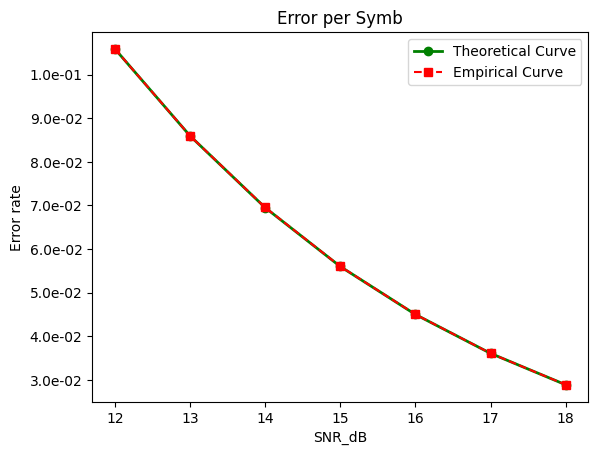

In [20]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(init_scale, init_scale + interval)
y2 = error_rate

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
ax.plot(x, y2, 'rs--', label='Empirical Curve')
ax.set_title('Error per Symb')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Error rate')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()